# ISTA410/INFO510 Final solutions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt

## Problem 1

In [2]:
bangla = pd.read_csv('bangladesh.csv', index_col = 0)
bangla.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


For reference we reproduce the model from HW5 below.

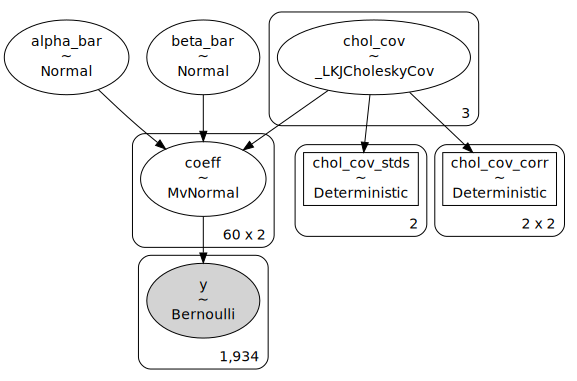

In [3]:
with pm.Model() as base_model:
    alpha_0_bar = pm.Normal('alpha_bar', 0, 1)
    alpha_1_bar = pm.Normal('beta_bar', 0, 1)
        
    sd_dist = pm.Exponential.dist(1)
        
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', eta = 2, n = 2, sd_dist = sd_dist, compute_corr = True)
    
    coeff = pm.MvNormal('coeff', mu = tt.stack([alpha_0_bar, alpha_1_bar]), chol=chol, shape=(60, 2))
    
    theta = pm.math.invlogit(coeff[bangla['district']-1, bangla['urban']])
    
    y_ = pm.Bernoulli('y', p=theta, observed = bangla['use.contraception'])

pm.model_to_graphviz(base_model)

### Part 1

We hypothesize the following causal effects:
* age influences number of children positively -- older women have had more time to have children
* age influences contraceptive use, probably negatively -- younger women have a more modern attitude, which is probably more liberal about contraception
* number of children may also influence contraceptive use directly

This is summarized in the following DAG, where A is age, nC is children, and U is usage of contraception.

![DAG](bangladesh_dag.png)

### Part 2

For part 2, we need two models: one with just age, and one with age and children. We'll start by setting up and diagramming the models, then do the sampling and inference.

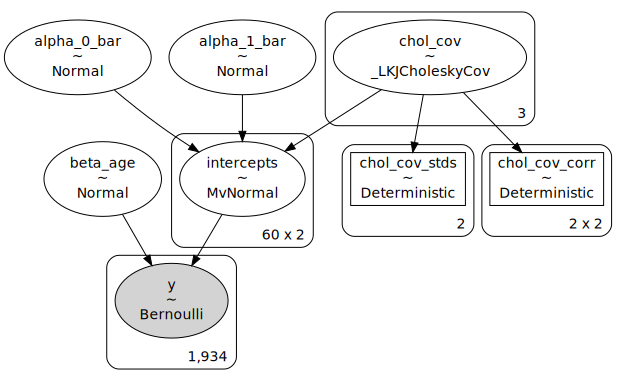

In [4]:
with pm.Model() as model_age:
    alpha_0_bar = pm.Normal('alpha_0_bar', 0, 1)
    alpha_1_bar = pm.Normal('alpha_1_bar', 0, 1)
    beta_age = pm.Normal('beta_age', 0, 1)
        
    sd_dist = pm.Exponential.dist(1)
        
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', eta = 2, n = 2, sd_dist = sd_dist, compute_corr = True)
    
    intercepts = pm.MvNormal('intercepts', mu = tt.stack([alpha_0_bar, alpha_1_bar]), chol=chol, shape=(60, 2))
    
    theta = pm.math.invlogit(intercepts[bangla['district']-1, bangla['urban']] + beta_age * bangla['age.centered'])
    
    y_ = pm.Bernoulli('y', p=theta, observed = bangla['use.contraception'])

pm.model_to_graphviz(model_age)

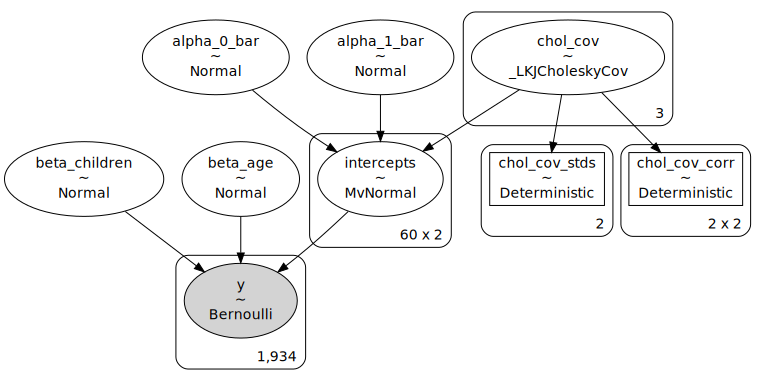

In [5]:
with pm.Model() as model_both:
    alpha_0_bar = pm.Normal('alpha_0_bar', 0, 1)
    alpha_1_bar = pm.Normal('alpha_1_bar', 0, 1)
    beta_age = pm.Normal('beta_age', 0, 1)
    beta_children = pm.Normal('beta_children', 0, 1)
        
    sd_dist = pm.Exponential.dist(1)
        
    chol, corr, sd = pm.LKJCholeskyCov('chol_cov', eta = 2, n = 2, sd_dist = sd_dist, compute_corr = True)
    
    intercepts = pm.MvNormal('intercepts', mu = tt.stack([alpha_0_bar, alpha_1_bar]), chol=chol, shape=(60, 2))
    
    theta = pm.math.invlogit(intercepts[bangla['district']-1, bangla['urban']] + beta_age * bangla['age.centered'] + beta_children * bangla['living.children'])
    
    y_ = pm.Bernoulli('y', p=theta, observed = bangla['use.contraception'])

pm.model_to_graphviz(model_both)

Sampling and inference:

In [6]:
with model_age:
    age_trace = pm.sample(2000, chains=4, cores=4, target_accept = 0.98, tune = 2000)
    age_summary = az.summary(age_trace, var_names = ['alpha_0_bar', 'alpha_1_bar', 'beta_age'])
    
with model_both:
    both_trace = pm.sample(2000, chains=4, cores=4, target_accept = 0.98, tune = 2000)
    both_summary = az.summary(both_trace, var_names = ['alpha_0_bar', 'alpha_1_bar', 'beta_age', 'beta_children'])

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercepts, chol_cov, beta_age, alpha_1_bar, alpha_0_bar]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 159 seconds.
The number of effective samples is smaller than 10% for some parameters.
/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercepts, chol_cov, beta_children, beta_age, alpha_1_bar, alpha_0_bar]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 195 seconds.
The number of effective samples is smaller than 10% for some parameters.


### Part 3

In [7]:
age_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_0_bar,-0.717,0.107,-0.911,-0.508,0.001,0.001,5263.0,5152.0,1.0
alpha_1_bar,0.017,0.131,-0.245,0.247,0.003,0.002,2069.0,4120.0,1.0
beta_age,0.009,0.006,-0.001,0.020,0.000,0.000,9529.0,5922.0,1.0


The result shows a small, but detectable positive effect of age. According to the DAG, this estimates the total causal effect of age -- a slight increase in use of contraceptives. This is in contrast to the hypothesized negative effect. To separate out the direct effect of age (which may be due to changing attitudes) with the effect mediated by number of children, we inspect the second model.

In [8]:
both_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_0_bar,-1.792,0.191,-2.145,-1.434,0.008,0.005,607.0,1594.0,1.01
alpha_1_bar,-0.995,0.198,-1.356,-0.620,0.008,0.006,623.0,1669.0,1.01
beta_age,-0.028,0.008,-0.044,-0.014,0.000,0.000,1001.0,2205.0,1.00
beta_children,0.399,0.057,0.297,0.509,0.003,0.002,510.0,1233.0,1.01


Again, we have a small but detectable effect of age, but the sign has reversed. `beta_age` now estimates the direct effect of age, and it is negative -- older women are less likely to use contraception, conditional on the number of children they already have. Number of children has a substantial positive effect on contraceptive use (enough to counterbalance the age effect, which is why the sign flipped in the other model). Notice also that the intercepts are much different in this model, because they now represent usage rates specifically among childless women, which are much lower. The gap between urban and rural remains, but is just a little bit wider.

In summary:
* age has a small negative effect on contraceptive use
* children have a large positive effect on contraceptive use
* the total effect of age, including the effect mediated by the presence of children, is small and positive (the effect of additional children balances out the direct effect of age)

## Problem 2

In [9]:
langdata = pd.read_csv('nettle.csv', sep = ';')
langdata['llpc'] = np.log(langdata['num.lang'] / langdata['k.pop'])
langdata.head()

,country,num.lang,area,k.pop,num.stations,mean.growing.season,sd.growing.season,llpc
0,Algeria,18,2381741,25660,102,6.60,2.29,-7.262317
1,Angola,42,1246700,10303,50,6.22,1.87,-5.502521
2,Australia,234,7713364,17336,134,6.00,4.17,-4.305219
3,Bangladesh,37,143998,118745,20,7.40,0.73,-8.073816
4,Benin,52,112622,4889,7,7.14,0.99,-4.543499


### Part 1

We start off with a linear model using mean growing season and log-area as predictors.

In [10]:
with pm.Model() as mean_model:
    alpha = pm.Normal('alpha', 0, 3)
    beta_mean = pm.Normal('beta_mean', 0, 1)
    beta_area = pm.Normal('beta_area', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    theta = (alpha + beta_mean * langdata['mean.growing.season']
                   + beta_area * np.log(langdata['area']))
    y = pm.Normal('y', mu = theta, sigma = sigma, observed = langdata['llpc'])
    
    mean_trace = pm.sample(2000, chains=4, cores=4, target_accept = 0.9, tune = 2000)
    mean_summary = az.summary(mean_trace)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_area, beta_mean, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.


In [11]:
mean_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-2.660,1.706,-5.855,0.525,0.035,0.025,2426.0,2933.0,1.0
beta_mean,0.125,0.055,0.021,0.229,0.001,0.001,3504.0,4300.0,1.0
beta_area,-0.283,0.121,-0.507,-0.060,0.002,0.002,2605.0,3244.0,1.0
sigma,1.431,0.122,1.214,1.664,0.002,0.001,4394.0,4349.0,1.0


This result seems to support the hypothesis that longer growing seasons are associated with higher language diversity. Interestingly, higher area appears to be associated with somewhat lower language diversity. This is a bit of a confusing result, but area is likely confounded with some other variables. (One of the reasons to include area in the model in the first case: one could make a case for a DAG in which area influences growing season SD because a larger country has more distinct local climates and topographical regions. If area also influences language diversity directly, then you get a backdoor "fork" path from SD to language diversity via area, so you close it by conditioning on area.)

### Part 2

In [12]:
with pm.Model() as sd_model:
    alpha = pm.Normal('alpha', 0, 3)
    beta_sd = pm.Normal('beta_sd', 0, 1)
    beta_area = pm.Normal('beta_area', 0, 1)
    sigma = pm.HalfCauchy('sigma', 1)
    
    theta = (alpha + beta_sd * langdata['sd.growing.season']
                   + beta_area * np.log(langdata['area']))
    y = pm.Normal('y', mu = theta, sigma = sigma, observed = langdata['llpc'])
    
    sd_trace = pm.sample(2000, chains=4, cores=4, target_accept = 0.9, tune = 2000)
    sd_summary = az.summary(sd_trace)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_area, beta_sd, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


In [13]:
sd_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.403,1.638,-4.461,1.703,0.032,0.023,2621.0,3066.0,1.0
beta_sd,-0.175,0.186,-0.535,0.168,0.003,0.002,3960.0,4625.0,1.0
beta_area,-0.290,0.136,-0.548,-0.037,0.003,0.002,2454.0,3141.0,1.0
sigma,1.478,0.127,1.249,1.718,0.002,0.001,5150.0,5009.0,1.0


Our hypothesis here is at best weakly supported; while the posterior mean estimate for `beta_sd` is negative, the posterior interval overlaps 0 substantially, so we don't have strong evidence for the claim that high variability in the growing season is associated with fewer languages.

### Part 3

In [14]:
with pm.Model() as interaction_model:
    alpha = pm.Normal('alpha', 0, 3)
    beta_mean = pm.Normal('beta_mean', 0, 1)
    beta_sd = pm.Normal('beta_sd', 0, 1)
    beta_area = pm.Normal('beta_area', 0, 1)
    beta_interaction = pm.Normal('beta_interaction', 0, 0.25)
    sigma = pm.HalfCauchy('sigma', 1)
    
    theta = (alpha + beta_mean * langdata['mean.growing.season']
                   + beta_sd * langdata['sd.growing.season'] 
                   + beta_interaction * langdata['mean.growing.season'] * langdata['sd.growing.season']
                   + beta_area * np.log(langdata['area']))
    
    y = pm.Normal('y', mu = theta, sigma = sigma, observed = langdata['llpc'])
    
    interaction_trace = pm.sample(2000, chains=4, cores=4, target_accept = 0.9, tune = 2000)
    interaction_summary = az.summary(interaction_trace)

/home/dylan/.conda/envs/info510/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_interaction, beta_area, beta_sd, beta_mean, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.


In [15]:
interaction_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-4.449,1.771,-7.738,-1.146,0.029,0.021,3731.0,4069.0,1.0
beta_mean,0.241,0.073,0.105,0.379,0.001,0.001,3874.0,4329.0,1.0
beta_sd,0.359,0.370,-0.283,1.096,0.006,0.004,3665.0,4402.0,1.0
beta_area,-0.173,0.134,-0.418,0.086,0.002,0.002,3810.0,3992.0,1.0
beta_interaction,-0.088,0.045,-0.174,-0.003,0.001,0.001,3480.0,4328.0,1.0
sigma,1.374,0.119,1.160,1.602,0.002,0.001,4727.0,4452.0,1.0


This is where things start to get a bit interesting. We now get two convincingly nonzero effects: the mean-length effect, which persists from the original model, and the interaction effect. This suggests that the negative effect with SD strengthens with increasing mean growing season. When growing seasons are short, the variability doesn't matter as much. (In order to interpret this, we need to keep in mind the numerical scale of growing seasons. Mostly, the shortest ones are under around 5 months -- see the summary below. In this range, the positive effect from the SD and the negative interaction effect roughly cancel. As the growing seasons get longer, the interaction effect outweighs the SD effect, so that SD is de facto associated with fewer languages.)

In [16]:
langdata.describe()

,num.lang,area,k.pop,num.stations,mean.growing.season,sd.growing.season,llpc
count,74.000000,7.400000e+01,74.000000,74.000000,74.000000,74.000000,74.000000
mean,89.729730,8.806982e+05,33574.067568,37.905405,7.041486,1.699189,-5.456606
std,144.156431,1.399199e+06,102226.246085,50.883205,3.143845,1.066081,1.520746
min,1.000000,1.218900e+04,102.000000,1.000000,0.000000,0.000000,-9.281358
25%,17.250000,1.677075e+05,3828.750000,10.000000,5.347500,0.937500,-6.219626
50%,40.000000,4.347960e+05,9487.000000,20.500000,7.355000,1.690000,-5.495184
75%,93.750000,1.080316e+06,24744.500000,44.750000,9.282500,2.107500,-4.611131
max,862.000000,8.511965e+06,849638.000000,272.000000,12.000000,5.870000,-0.384220


## Problem 3

In [17]:
naes = pd.read_csv('naes_favor_grouped.csv', index_col = 0)
naes.head()

,age,yes,n
0,18,374,981
1,19,237,674
2,20,260,687
3,21,315,850
4,22,306,891


### Part 1

We start by computing proportions and making a scatter plot so we can see what's going on.

In [18]:
naes['prop_yes'] = naes['yes'] / naes['n']

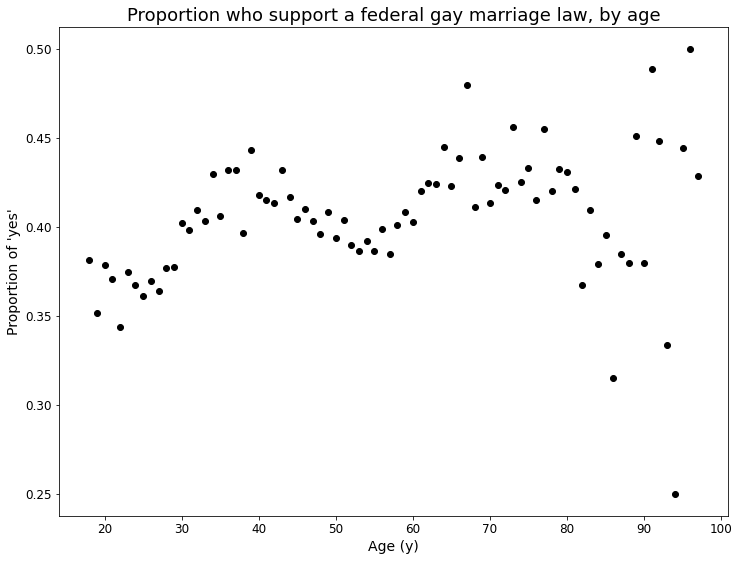

In [19]:
plt.figure(figsize=(12, 9))
plt.plot(naes['age'], naes['prop_yes'], 'o', color = 'k')
plt.xlabel('Age (y)', size=14)
plt.ylabel('Proportion of \'yes\'', size=14)
plt.tick_params(labelsize=12)
plt.title('Proportion who support a federal gay marriage law, by age', size=18)
plt.show()

What makes this interesting? It's non-monotonic, which is maybe a bit surprising given that we might expect support to roughly decrease with age. There are a few distinct peaks and troughs. There's not an obvious parametric function to try to fit here, so a non-parametric model like a GP is a reasonable choice.

### Part 2

We'll start with a Matern(3/2) covariance function.

In [20]:
with pm.Model() as naes_model:
    eta = pm.Exponential('eta', 1)
    ls = pm.Exponential('ls', 1/5)
    sigma = pm.HalfCauchy('sigma', 1)
    
    cov_func = eta ** 2 * pm.gp.cov.Matern32(1, ls=ls)
    gp_fit = pm.gp.Marginal(cov_func = cov_func)
    
    y_ = gp_fit.marginal_likelihood('y', X = naes.age.values[:, None], y=naes.prop_yes.values, noise = sigma)
    mp = pm.find_MAP()

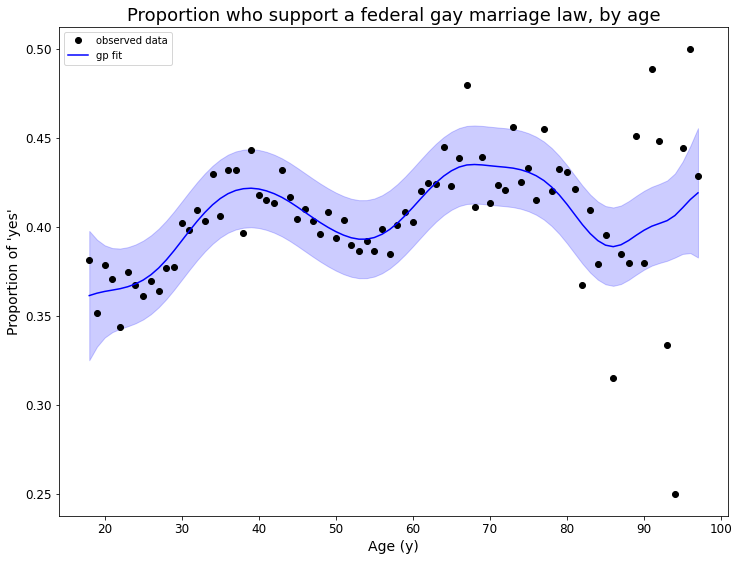

In [21]:
mu, var = gp_fit.predict(Xnew = naes.age.values[:, None], point = mp, diag = True)

plt.figure(figsize=(12, 9))
plt.plot(naes['age'], naes['prop_yes'], 'o', color = 'k', label = 'observed data')
plt.plot(naes['age'], mu, color = 'blue', label = 'gp fit')
plt.fill_between(x=naes['age'], y1 = mu - 2*np.sqrt(var), y2 = mu + 2*np.sqrt(var), color = 'blue', alpha = 0.2)
plt.xlabel('Age (y)', size=14)
plt.ylabel('Proportion of \'yes\'', size=14)
plt.tick_params(labelsize=12)
plt.title('Proportion who support a federal gay marriage law, by age', size=18)
plt.legend()
plt.show()

### Part 3

For contrast, we try an exponentiated quadratic kernel (should be very smooth) and an exponential kernel (should be rough).

In [22]:
with pm.Model() as naes_model_expquad:
    eta = pm.Exponential('eta', 1)
    ls = pm.Exponential('ls', 1/5)
    sigma = pm.HalfCauchy('sigma', 1)
    
    cov_func = eta ** 2 * pm.gp.cov.ExpQuad(1, ls=ls)
    gp_fit_expquad = pm.gp.Marginal(cov_func = cov_func)
    
    y_ = gp_fit_expquad.marginal_likelihood('y', X = naes.age.values[:, None], y=naes.prop_yes.values, noise = sigma)
    mp_expquad = pm.find_MAP()

In [23]:
with pm.Model() as naes_model_exp:
    eta = pm.Exponential('eta', 1)
    ls = pm.Exponential('ls', 1/5)
    sigma = pm.HalfCauchy('sigma', 1)
    
    cov_func = eta ** 2 * pm.gp.cov.Exponential(1, ls=ls)
    gp_fit_exp = pm.gp.Marginal(cov_func = cov_func)
    
    y_ = gp_fit_exp.marginal_likelihood('y', X = naes.age.values[:, None], y=naes.prop_yes.values, noise = sigma)
    mp_exp = pm.find_MAP()

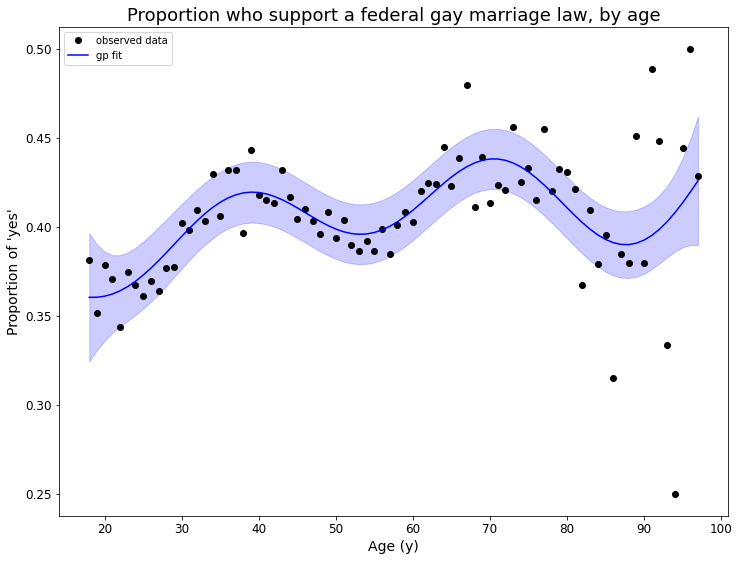

In [24]:
mu, var = gp_fit_expquad.predict(Xnew = naes.age.values[:, None], point = mp_expquad, diag = True)

plt.figure(figsize=(12, 9))
plt.plot(naes['age'], naes['prop_yes'], 'o', color = 'k', label = 'observed data')
plt.plot(naes['age'], mu, color = 'blue', label = 'gp fit')
plt.fill_between(x=naes['age'], y1 = mu - 2*np.sqrt(var), y2 = mu + 2*np.sqrt(var), color = 'blue', alpha = 0.2)
plt.xlabel('Age (y)', size=14)
plt.ylabel('Proportion of \'yes\'', size=14)
plt.tick_params(labelsize=12)
plt.title('Proportion who support a federal gay marriage law, by age', size=18)
plt.legend()
plt.show()

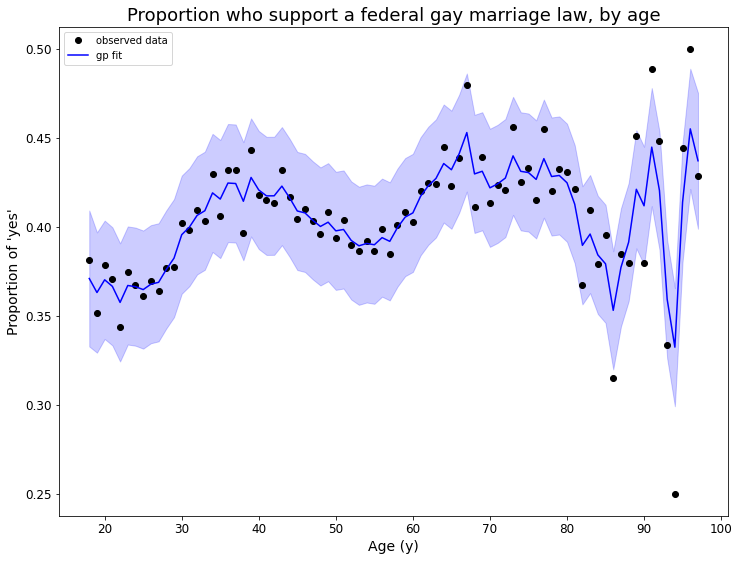

In [25]:
mu, var = gp_fit_exp.predict(Xnew = naes.age.values[:, None], point = mp_exp, diag = True)

plt.figure(figsize=(12, 9))
plt.plot(naes['age'], naes['prop_yes'], 'o', color = 'k', label = 'observed data')
plt.plot(naes['age'], mu, color = 'blue', label = 'gp fit')
plt.fill_between(x=naes['age'], y1 = mu - 2*np.sqrt(var), y2 = mu + 2*np.sqrt(var), color = 'blue', alpha = 0.2)
plt.xlabel('Age (y)', size=14)
plt.ylabel('Proportion of \'yes\'', size=14)
plt.tick_params(labelsize=12)
plt.title('Proportion who support a federal gay marriage law, by age', size=18)
plt.legend()
plt.show()

Qualitatively, the "best" result seems to come from either the ExpQuad or the Matern kernels, which are similar (but the Matern gives slightly less smooth curves). The Exponential kernel gives a very rough result (as we expect).

#### Appendix to Problem 3

Here's a thing we didn't cover in class, so I'm not expecting it on the final, but it's worth mentioning. When converting to proportions we lose some information: the total count of observations. Why is this a problem? You can see it on the right side of the plot. The observed points become very spread out, which is to be expected -- there are fewer observations at very high age, and proportions from smaller sample sizes are more variable. The fancy term for this is *heteroscedasticity* (yeah, I had to look it up to spell it), but it just means non-constant variance. 

The variance in observations in our model is determined by the `noise` parameter in `marginal_likelihood` (really, this is the standard deviation, not the variance). Because we just pass this a single variable `sigma`, our model has constant variance in the likelihood (homoscedastic) -- but our data doesn't (heteroscedastic). The result is that our confidence band is too wide near the left of the plot, where the sample sizes are high, and too narrow toward the right, where they are low.

Here's a simple adjustment. The sample proportions here should be approximately normally distributed (normal approximation to the Gaussian) which is what justifies our use of the Marginal implementation here. We know that the standard deviation of these sample proportions should go like $1/\sqrt{n}$. So instead of `noise = sigma` we plug in `noise = sigma / np.sqrt(naes.n)` to get noise that varies according to the sample size. We'll see that the 2 sigma band misses a few points on the left (as it should) and covers more points on the right.

In [26]:
with pm.Model() as naes_model:
    eta = pm.Exponential('eta', 1)
    ls = pm.Exponential('ls', 1/5)
    sigma = pm.HalfCauchy('sigma', 1)
    
    cov_func = eta ** 2 * pm.gp.cov.Matern32(1, ls=ls)
    gp_fit = pm.gp.Marginal(cov_func = cov_func)
    
    y_ = gp_fit.marginal_likelihood('y', X = naes.age.values[:, None], y=naes.prop_yes.values, noise = sigma / np.sqrt(naes.n))
    mp = pm.find_MAP()

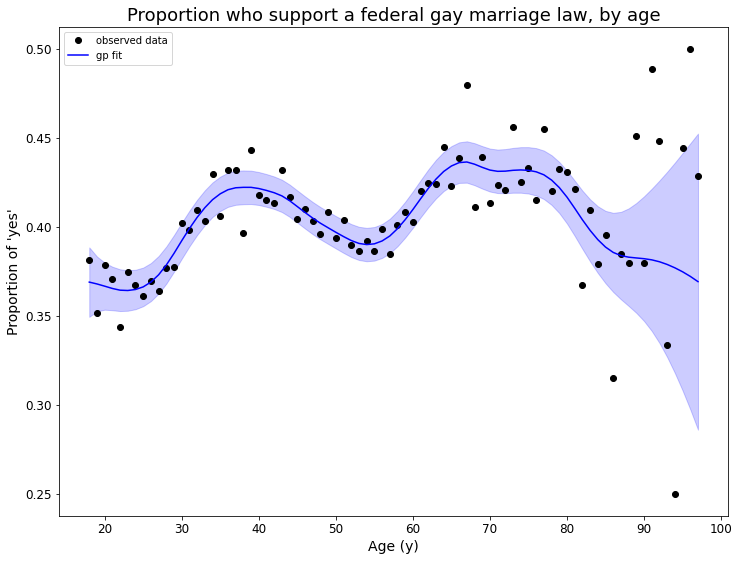

In [27]:
mu, var = gp_fit.predict(Xnew = naes.age.values[:, None], point = mp, diag = True)

plt.figure(figsize=(12, 9))
plt.plot(naes['age'], naes['prop_yes'], 'o', color = 'k', label = 'observed data')
plt.plot(naes['age'], mu, color = 'blue', label = 'gp fit')
plt.fill_between(x=naes['age'], y1 = mu - 2*np.sqrt(var), y2 = mu + 2*np.sqrt(var), color = 'blue', alpha = 0.2)
plt.xlabel('Age (y)', size=14)
plt.ylabel('Proportion of \'yes\'', size=14)
plt.tick_params(labelsize=12)
plt.title('Proportion who support a federal gay marriage law, by age', size=18)
plt.legend()
plt.show()